In [1]:
import cv2
import imghdr
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = 'data'

In [4]:
image_exts = ['jpeg','jpg','bmp','png']

In [5]:
for image_class in os.listdir(data_dir):
    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            
            if tip not in image_exts:
                print ('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
              print('Issue with image {}'.format(image_path))
              os.remove(image_path)

In [6]:
# Define parameters for the loader
batch_size = 32
img_height = 255
img_width = 255

In [7]:
train = tf.keras.utils.image_dataset_from_directory(
    'data',
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)


Found 1013 files belonging to 2 classes.
Using 811 files for training.


In [8]:
val = tf.keras.utils.image_dataset_from_directory(
    'data',
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
    )

Found 1013 files belonging to 2 classes.
Using 202 files for validation.


In [9]:
class_names = train.class_names
print(class_names)

['cats', 'dogs']


In [10]:
for image,label in train:
    print(image.shape)
    print(label.shape)
    break

(32, 255, 255, 3)
(32,)


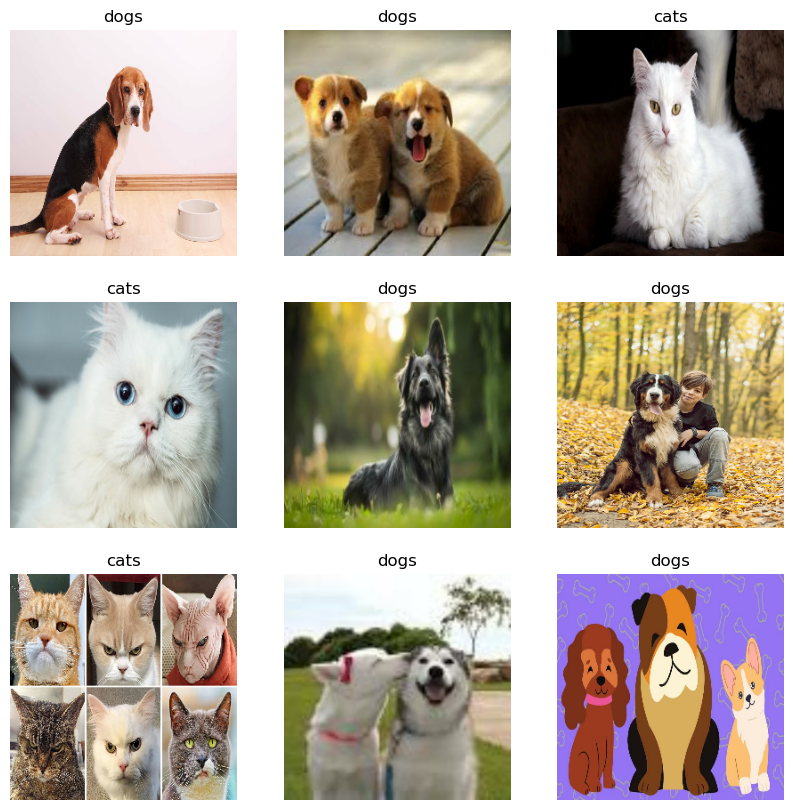

In [11]:
plt.figure (figsize=(10,10))

for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot (3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
plt.show()

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y))
val = val.map(lambda x, y: (normalization_layer(x), y))

In [13]:
image, labels = next(iter(train))
first_image = image[0]
print(np.min(first_image), np.max(first_image))

0.0 0.8944628


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(255,255,3)),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(255, activation ='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [24]:
results = model.fit(
    train,
    epochs=10,
    validation_data = val
    )

Epoch 1/10
26/26 [==============================] - 21s 698ms/step - loss: 0.8009 - accuracy: 0.5105 - val_loss: 0.7061 - val_accuracy: 0.4356
Epoch 2/10
26/26 [==============================] - 14s 534ms/step - loss: 0.6865 - accuracy: 0.5598 - val_loss: 0.6932 - val_accuracy: 0.5099
Epoch 3/10
26/26 [==============================] - 15s 563ms/step - loss: 0.6685 - accuracy: 0.6079 - val_loss: 0.6523 - val_accuracy: 0.6040
Epoch 4/10
26/26 [==============================] - 15s 574ms/step - loss: 0.6379 - accuracy: 0.6338 - val_loss: 0.6371 - val_accuracy: 0.6584
Epoch 5/10
26/26 [==============================] - 16s 619ms/step - loss: 0.5972 - accuracy: 0.6905 - val_loss: 0.5962 - val_accuracy: 0.6832
Epoch 6/10
26/26 [==============================] - 15s 570ms/step - loss: 0.5400 - accuracy: 0.7349 - val_loss: 0.5803 - val_accuracy: 0.7079
Epoch 7/10
26/26 [==============================] - 14s 539ms/step - loss: 0.4742 - accuracy: 0.7781 - val_loss: 0.5519 - val_accuracy: 0.7624

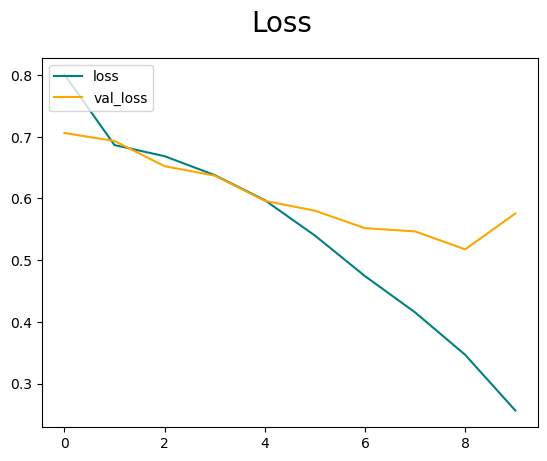

In [25]:
plt.figure()
plt.plot(results.history['loss'], color='teal', label='loss')
plt.plot(results.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [28]:
import numpy as np
from keras.preprocessing import image

1/1 [==============================] - 0s 36ms/step
Data Class Names:  ['cats', 'dogs']
Class Label Number:  1.0
This image most likely belongs to dogs with a 73.11 percent confidence.


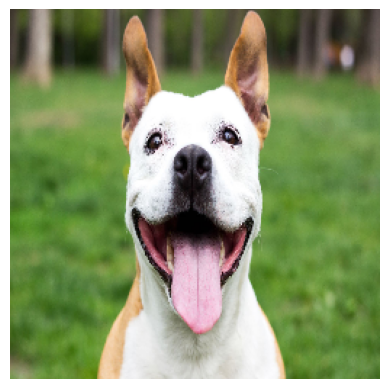

In [47]:
test_url = "https://ggsc.s3.amazonaws.com/images/uploads/The_Science-Backed_Benefits_of_Being_a_Dog_Owner.jpg"
test_path = tf.keras.utils.get_file('Dog', origin=test_url)

img = keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img)
plt.axis('Off')
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print('Data Class Names: ',class_names)
print('Class Label Number: ', predictions[0][0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(predictions[0][0])], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
Data Class Names:  ['cats', 'dogs']
Class Label Number:  0.0
This image most likely belongs to cats with a 50.00 percent confidence.


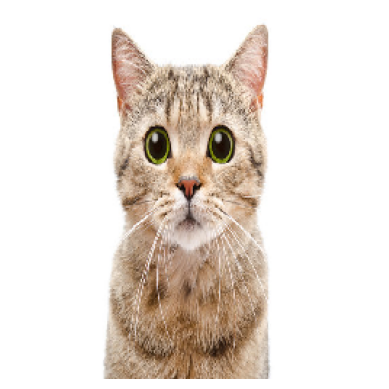

In [48]:
test_url = "https://t4.ftcdn.net/jpg/00/97/58/97/360_F_97589769_t45CqXyzjz0KXwoBZT9PRaWGHRk5hQqQ.jpg"
test_path = tf.keras.utils.get_file('Cat', origin=test_url)

img = keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img)
plt.axis('Off')
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print('Data Class Names: ',class_names)
print('Class Label Number: ', predictions[0][0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(predictions[0][0])], 100 * np.max(score))
)